# ** Описание **

In [1]:
import base64
import csv
import gzip
import zlib

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 1000
import logging
from importlib import reload
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, str):
        text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, str):
            try:
                text = text.decode('utf-8')
            except:
                try:
                    text = text.decode('cp1251')
                except:
                    text = text.decode('koi8_r')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum():
            word += symbol
        elif word:
            yield word
            word = str()
    if word:
        yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0:
        return 0.0
    elif b == 0:
        return 0.0
    else:
        return a / b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop:
            break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
import numpy as np
from bs4 import BeautifulSoup
from collections import Counter
from urllib import parse

def words_from_url(url):
    words = []
    
    parsed_url = parse.urlparse(url)
    
    for segment in parsed_url.netloc.split('.'):
        for sub_segment in segment.split('-'):
            for sub_sub_segment in sub_segment.split('_'):
                words.append(sub_sub_segment.lower())

    for segment in parse.unquote(parsed_url.path).split('/'):
        segment = segment.split('.')[0] # filter .html
        if segment == '':
            continue
        for sub_segment in segment.split('-'):
            for sub_sub_segment in sub_segment.split('_'):
                words.append(sub_sub_segment.lower())
                
    return words

In [11]:
def dict_mainer(input_file_name):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    N_w = Counter()
    N = 0
    idf = Counter()
    log = Counter()
    
    log_url = Counter()
    idf_url = Counter()
    N_w_url = Counter()
    
    domain_name_score = Counter()
    
    spam_urls = []
    NO_spam_urls = []
    
    spam_voc = Counter()
    NO_spam_voc = Counter()
    good_words = Counter()
    spam_words = Counter()
    
    spam_voc_url = Counter()
    NO_spam_voc_url = Counter()
    
    spam_domain_names = Counter()
    NO_spam_domain_names = Counter()
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name, 'r') as input_file:            
        headers = input_file.readline()
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.decode('utf-8').strip().split('\t')
            spam = bool(int(parts[1]))
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            words = set(html2word(html_data))
            for word in words:
                N_w[word] += 1
                if spam:
                    spam_voc[word] += 1
                else:
                    NO_spam_voc[word] += 1
            
            url_words = words_from_url(url)
            
            for word in url_words:
                N_w_url[word] += 1
                if spam:
                    spam_voc_url[word] += 1
                else:
                    NO_spam_voc_url[word] += 1
            
            if spam:
                spam_urls.append(url)
            else:
                NO_spam_urls.append(url)
            

            N += 1
            
            parsed_url = parse.urlparse(url)
            
            domain_name = parsed_url.netloc.split('.')[-1]
            
            if spam:
                spam_domain_names[domain_name] += 1
            else:
                NO_spam_domain_names[domain_name] += 1
                
        trace(i, 1)
    
    for word in N_w:
        idf[word] = np.log((N + 1) / (N_w[word] + 1))
        
    for word in N_w_url:
        idf_url[word] = np.log((N + 1) / (N_w_url[word] + 1))
        
    for word in spam_voc:
        if word in NO_spam_voc:
            log[word] = np.log(spam_voc[word] / NO_spam_voc[word])
            
    for word in spam_voc_url:
        if word in NO_spam_voc_url:
            log_url[word] = np.log(spam_voc_url[word] / NO_spam_voc_url[word])
            
    for word in spam_domain_names:
        domain_name_score[word] = (spam_domain_names[word] / (NO_spam_domain_names[word] + spam_domain_names[word]) - 0.5) * 2
    
    for word in NO_spam_domain_names:
        domain_name_score[word] = (spam_domain_names[word] / (NO_spam_domain_names[word] + spam_domain_names[word]) - 0.5) * 2
    
    for word in spam_voc:
        if word not in NO_spam_voc:
            spam_words[word] = spam_voc[word]
            
    for word in NO_spam_voc:
        if word not in spam_voc:
            good_words[word] = NO_spam_voc[word]
    
    return idf, idf_url, log, log_url, domain_name_score, spam_words, good_words

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [12]:
TRAIN_DATA_FILE  = './kaggle_train_data_tab.csv.gz'

In [13]:
%%time

idf, idf_url, log, log_url, domain_name_score, spam_words, good_words = dict_mainer(TRAIN_DATA_FILE)

17:43:21 INFO:Complete items 00000
17:43:34 INFO:Complete items 01000
17:43:46 INFO:Complete items 02000
17:44:00 INFO:Complete items 03000
17:44:14 INFO:Complete items 04000
17:44:28 INFO:Complete items 05000
17:44:42 INFO:Complete items 06000
17:44:57 INFO:Complete items 07000
17:44:57 INFO:Complete items 07043


CPU times: user 1min 34s, sys: 1.02 s, total: 1min 35s
Wall time: 1min 38s


In [14]:
def dict_plotter(counter, color, num, reverse=False):
    labels = []
    scores = []
    if reverse:
        container = counter.most_common()[::-1][:num]
    else:
        container = counter.most_common(num)
    for word, score in container:
        labels.append(word)
        scores.append(score)
    plt.figure(figsize=(20,5))
    plt.bar(labels, scores, color=color)
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.figure()
    plt.show()

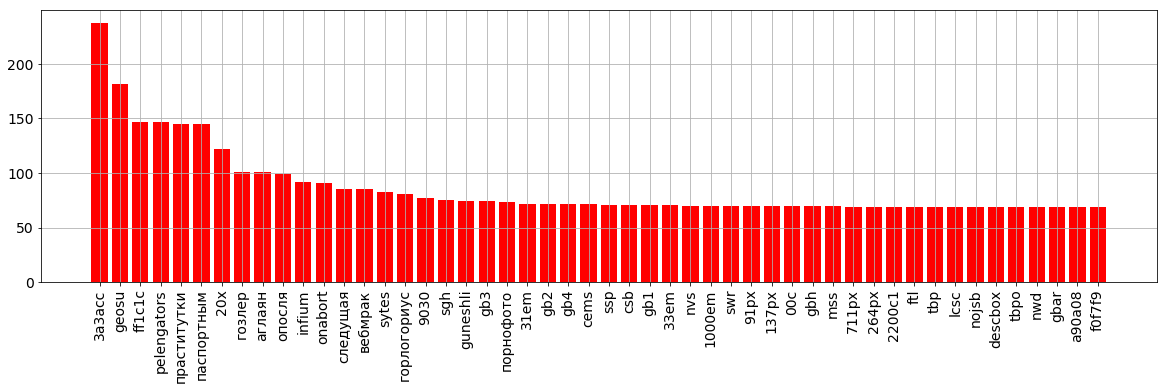

<Figure size 432x288 with 0 Axes>

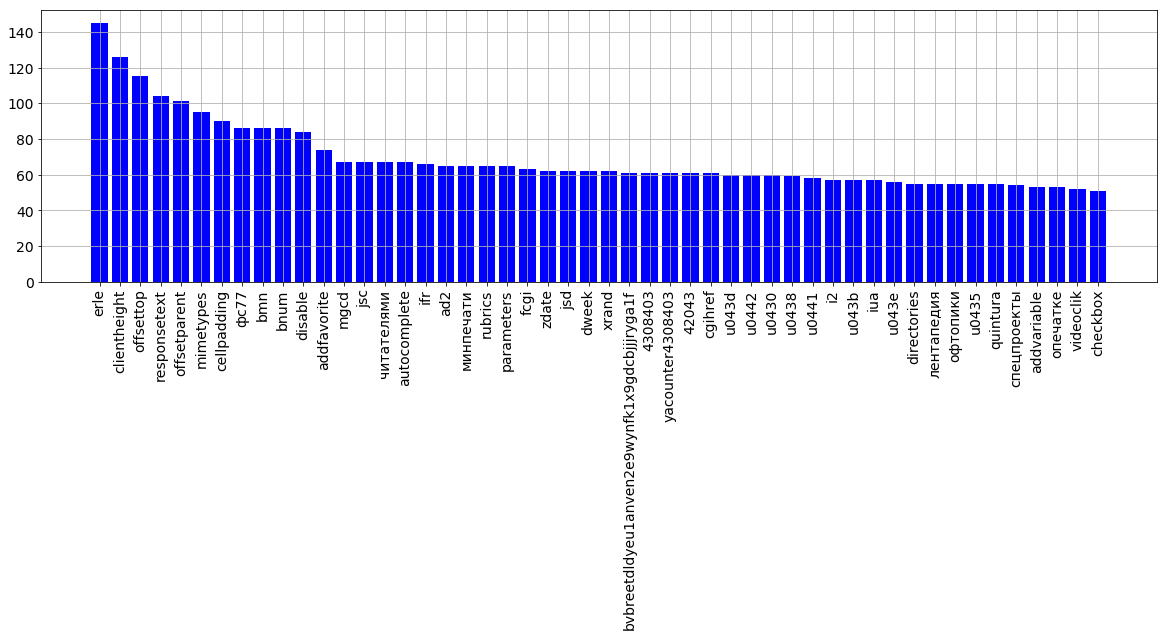

<Figure size 432x288 with 0 Axes>

In [15]:
dict_plotter(spam_words, num=50, color='red')
dict_plotter(good_words, num=50, color='blue')

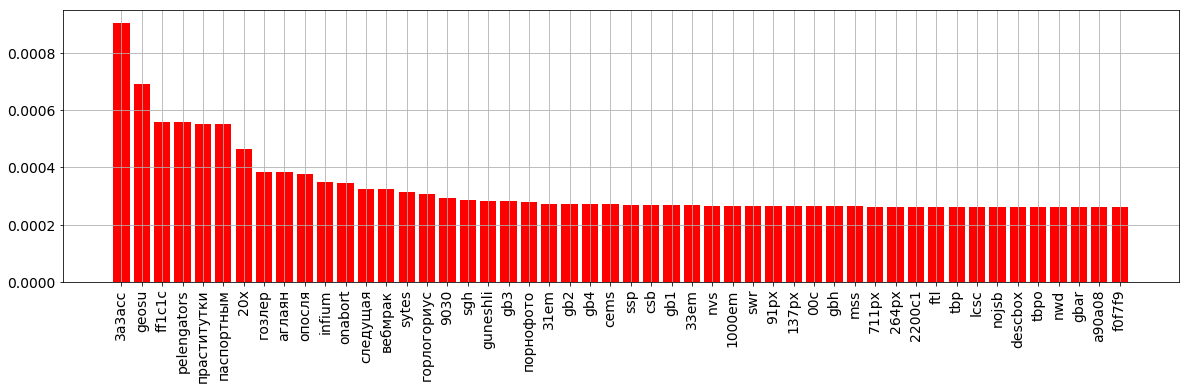

<Figure size 432x288 with 0 Axes>

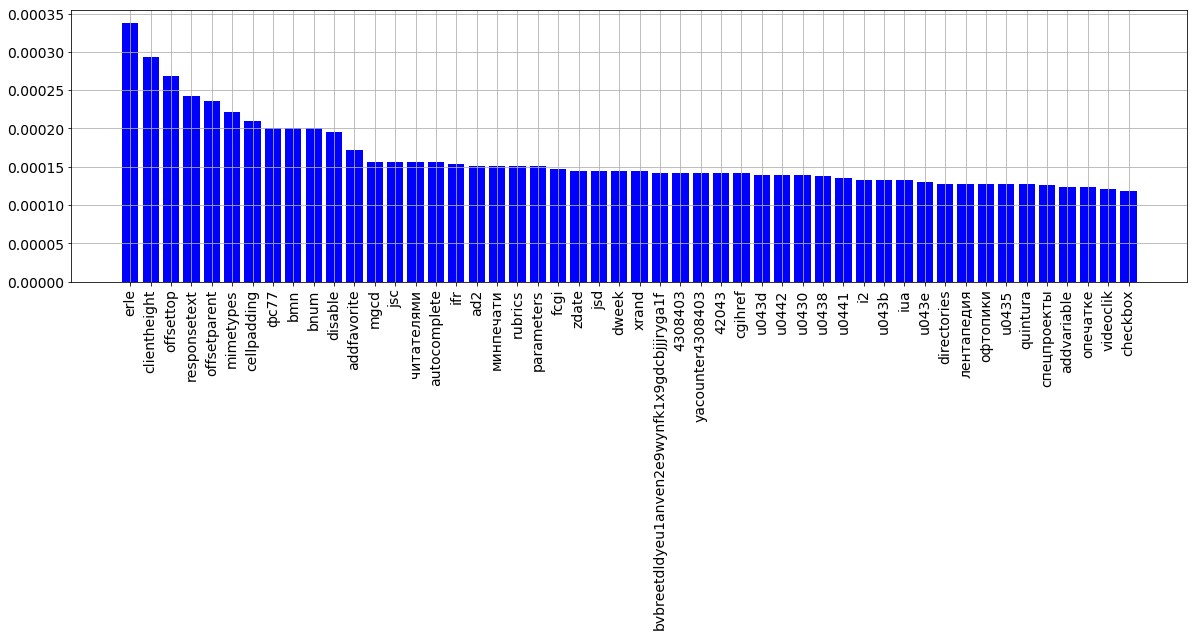

<Figure size 432x288 with 0 Axes>

In [16]:
def normalize(x):
    normed_x = Counter()
    total = sum(x.values(), 0.0)
    for key in x:
        normed_x[key] = x[key] / total
    return normed_x
    

good_words_normed = normalize(good_words)
spam_words_normed = normalize(spam_words)


dict_plotter(spam_words_normed, num=50, color='red')
dict_plotter(good_words_normed, num=50, color='blue')

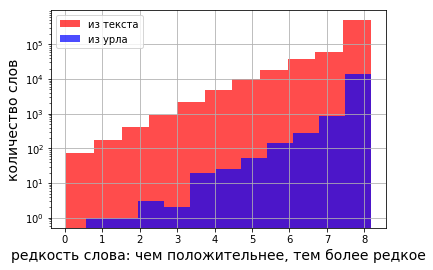

In [17]:
plt.hist(idf.values(), bins=11, color='red', alpha=0.7, label='из текста')
plt.hist(idf_url.values(), bins=11, color='blue', alpha=0.7, label='из урла')
plt.grid()
plt.xlabel('редкость слова: чем положительнее, тем более редкое', fontsize=14)
plt.ylabel('количество слов', fontsize=14)
plt.yscale('log')
plt.legend()
plt.show()

### самые редкие в коллекции слова

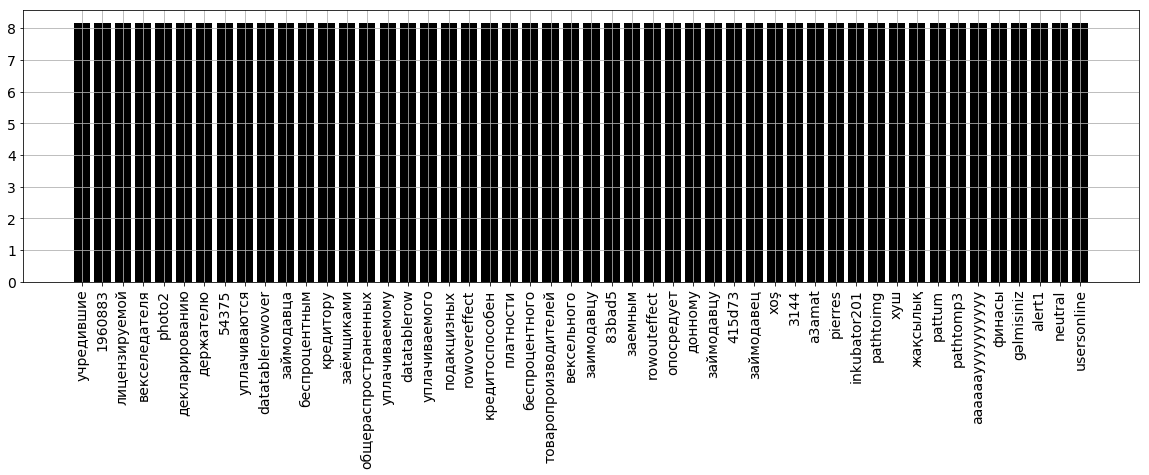

<Figure size 432x288 with 0 Axes>

In [18]:
dict_plotter(idf, color='black', num=50)

### самые частые в коллекции слова

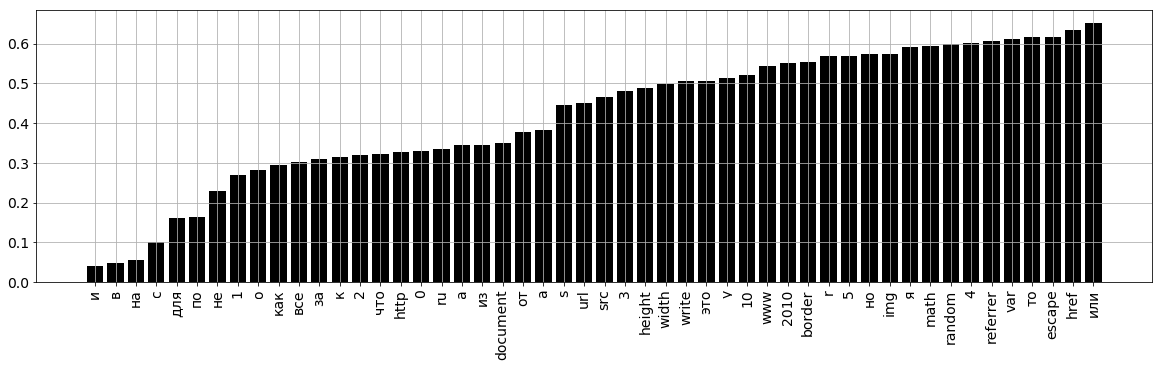

<Figure size 432x288 with 0 Axes>

In [19]:
dict_plotter(idf, color='black', num=50, reverse=True)

### самые редкие в урлах слова

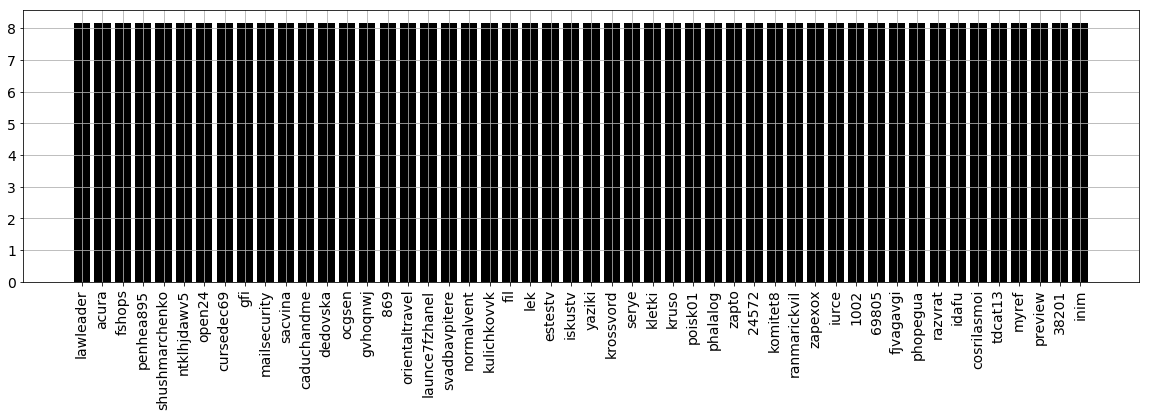

<Figure size 432x288 with 0 Axes>

In [20]:
dict_plotter(idf_url, color='black', num=50)

### самые частые в урлах слова

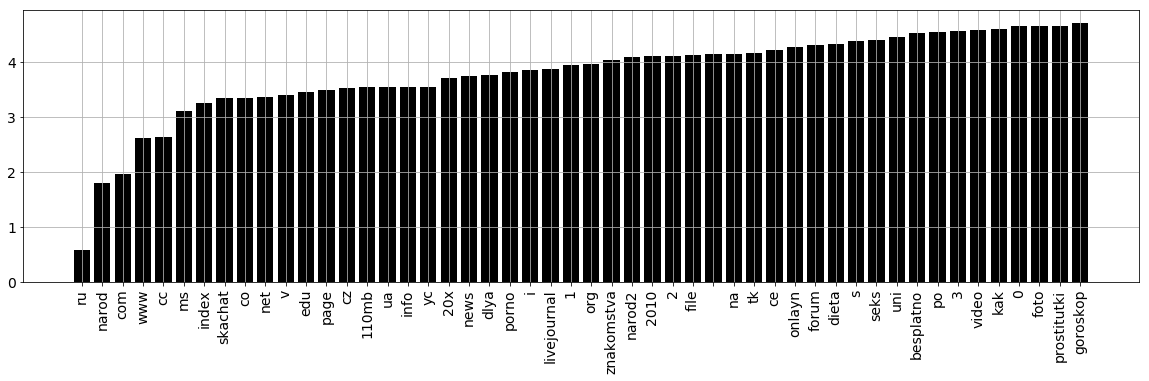

<Figure size 432x288 with 0 Axes>

In [21]:
dict_plotter(idf_url, color='black', num=50, reverse=True)

### главные спам-слова

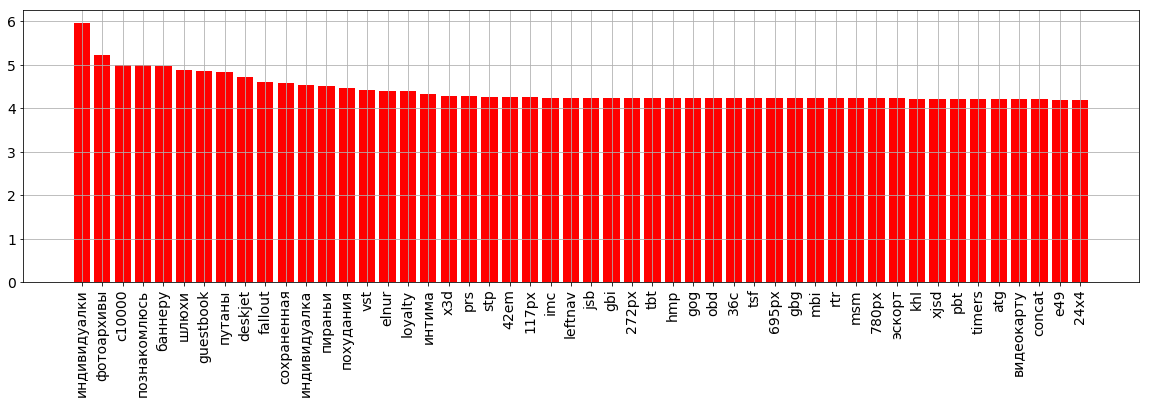

<Figure size 432x288 with 0 Axes>

In [22]:
dict_plotter(log, color='red', num=50)

In [56]:
100 * 7000 * 8 / 1024 / 1024

5.340576171875

In [54]:
log.most_common(300)

[('индивидуалки', 5.958424693029782),
 ('фотоархивы', 5.220355825078324),
 ('c10000', 4.990432586778736),
 ('познакомлюсь', 4.990432586778736),
 ('баннеру', 4.962844630259907),
 ('шлюхи', 4.879006851617819),
 ('guestbook', 4.852030263919617),
 ('путаны', 4.836281906951478),
 ('deskjet', 4.718498871295094),
 ('fallout', 4.61512051684126),
 ('сохраненная', 4.574710978503383),
 ('индивидуалка', 4.543294782270004),
 ('пираньи', 4.5217885770490405),
 ('похудания', 4.465908118654584),
 ('vst', 4.430816798843313),
 ('elnur', 4.394449154672439),
 ('loyalty', 4.394449154672439),
 ('интима', 4.324132656254979),
 ('x3d', 4.290459441148391),
 ('prs', 4.290459441148391),
 ('stp', 4.2626798770413155),
 ('42em', 4.2626798770413155),
 ('117px', 4.248495242049359),
 ('imc', 4.23410650459726),
 ('leftnav', 4.23410650459726),
 ('jsb', 4.23410650459726),
 ('gbi', 4.23410650459726),
 ('272px', 4.23410650459726),
 ('tbt', 4.23410650459726),
 ('hmp', 4.23410650459726),
 ('gog', 4.23410650459726),
 ('obd', 4.

### главные НЕспам-слова

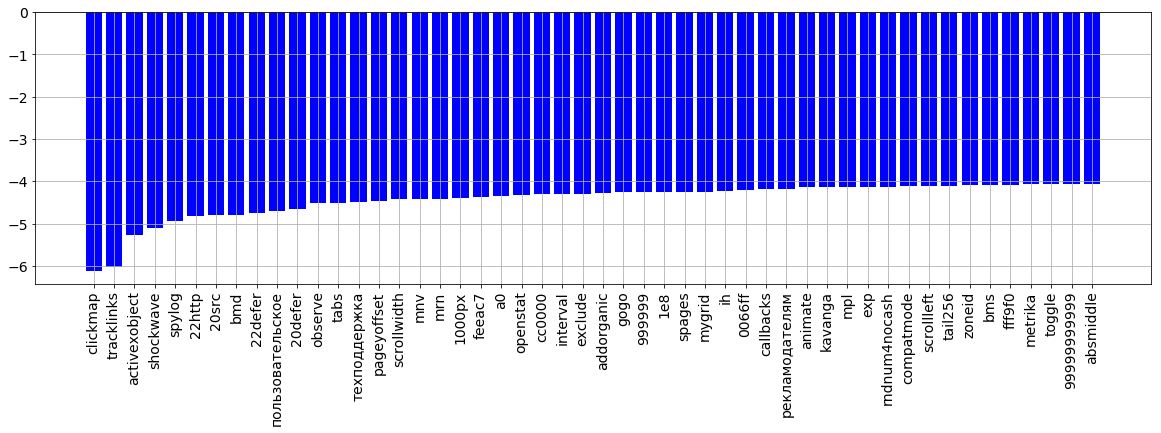

<Figure size 432x288 with 0 Axes>

In [23]:
dict_plotter(log, color='blue', num=50, reverse=True)

### нейтральные слова

In [24]:
threshold = 0.002
max_print = 20
print_count = 0

for word, score in log.most_common():
    if print_count > max_print:
        break
    if score < threshold and score > -threshold:
        print(word, score)
        print_count += 1

the 0.0016625107736134572
дании 0.0
панкратов 0.0
баллов 0.0
шадрин 0.0
запросов 0.0
дч 0.0
atlant 0.0
sva 0.0
olymp 0.0
эк 0.0
иерей 0.0
неизбежности 0.0
сомнением 0.0
невскому 0.0
демократы 0.0
благородству 0.0
милости 0.0
скотским 0.0
ужасна 0.0
интернете 0.0


нейтральных слов очень много...

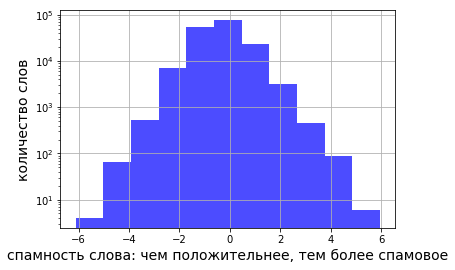

In [25]:
plt.hist(log.values(), bins=11, color='blue', alpha=0.7)
plt.grid()
plt.xlabel('спамность слова: чем положительнее, тем более спамовое', fontsize=14)
plt.ylabel('количество слов', fontsize=14)
plt.yscale('log')
plt.show()

In [26]:
log['спам']

-0.7419373447293773

In [27]:
log['халява']

1.4604023332736125

В принципе, если отфильтровать нейтральные слова, то фича хорошая

### Главные спам-слова в урлах 

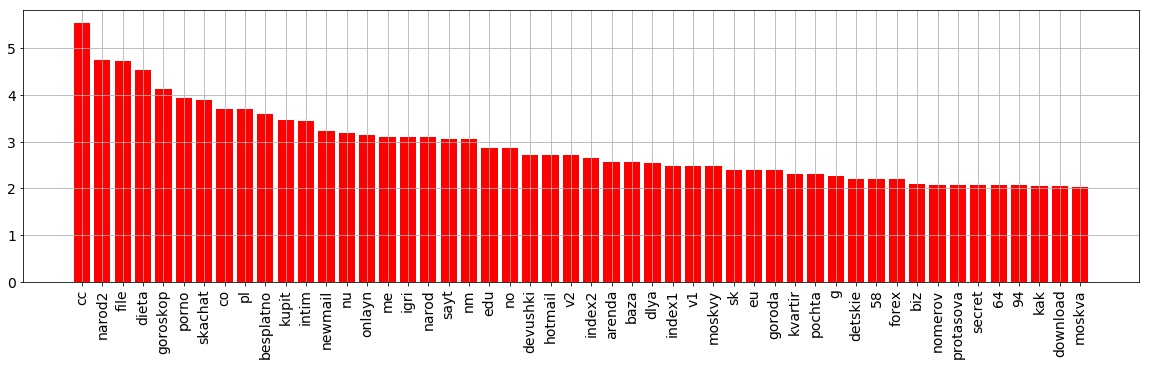

<Figure size 432x288 with 0 Axes>

In [28]:
dict_plotter(log_url, color='red', num=50)

### Главные НЕспам-слова в урлах

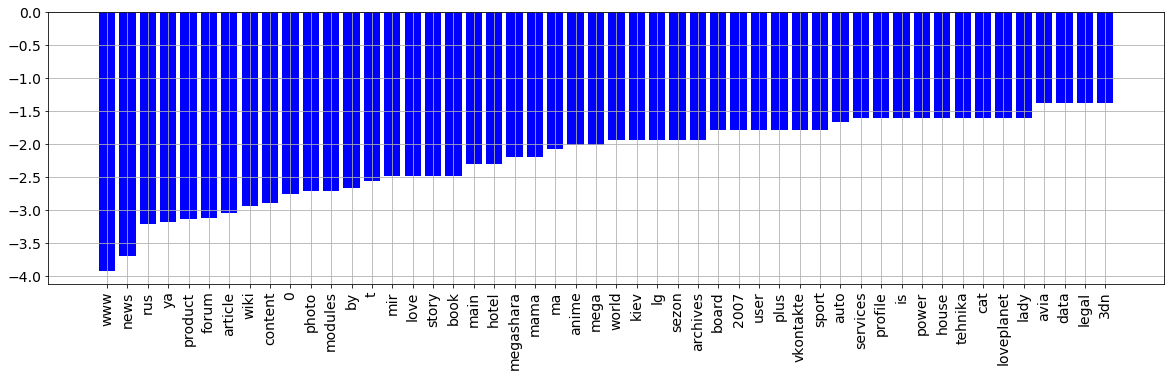

<Figure size 432x288 with 0 Axes>

In [29]:
dict_plotter(log_url, color='blue', num=50, reverse=True)

### Нейтральные слова в урлах

In [30]:
threshold = 0.002
max_print = 20
print_count = 0

for word, score in log_url.most_common():
    if print_count > max_print:
        break
    if score < threshold and score > -threshold:
        print(word, score)
        print_count += 1

v8 0.0
zhenu 0.0
baku 0.0
avto 0.0
dj 0.0
120 0.0
157 0.0
spravka 0.0
41 0.0
a7 0.0
ufa 0.0
30 0.0
lokomotiv 0.0
theme 0.0
ufo 0.0
19 0.0
mexa 0.0
massazh 0.0
mgts 0.0
39 0.0
06 0.0


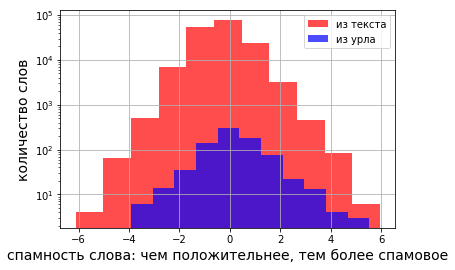

In [31]:
plt.hist(log.values(), bins=11, color='red', alpha=0.7, label='из текста')
plt.hist(log_url.values(), bins=11, color='blue', alpha=0.7, label='из урла')
plt.grid()
plt.xlabel('спамность слова: чем положительнее, тем более спамовое', fontsize=14)
plt.ylabel('количество слов', fontsize=14)
plt.yscale('log')
plt.legend()
plt.show()

# Генерация признаков

__Признаки, которые парсились, но не подошли из-за совпадения распределений и/или низкого скора RandomForest__:
* средняя длина слова в документе
* средний IDF слова в документе
* дисперсия IDF слова в документе
* количество слов в <title\>
* средняя длина урла из <a "href=url"\>
* кол-во <div\>
* кол-во <table\>
* кол-во <p\>
* кол-во сегментов в урле
* доля порно-слов в документе(начинающихся с хуе..., пизд..., проститут... и еще 7 слов)

In [32]:
def digits_ratio_in_word(word):
    if word == '':
        return 0
    digits_count = 0
    for w in word:
        if w.isdigit():
            digits_count += 1
    return digits_count / len(word)

In [33]:
def calc_features(url, html_data, idf_dict, idf_url_dict, log_dict,
                  log_url_dict, good_words, spam_words, normed_good_words, normed_spam_words):
    words = list(html2word(html_data))
    words_num = len(words)
    avg_digits_ratio = np.mean([digits_ratio_in_word(word) for word in words]) 
    
    soup = BeautifulSoup(html_data, 'lxml')
    
    urls = soup.find_all('a', href=True)
    
    try:
        anchor_words_len = [len(href.contents[0].strip().split(' ')) for href in urls]
    except:
        anchor_words_len = []
    
    if anchor_words_len:
        anchor_words_avg_len = np.mean(anchor_words_len)
    else:
        anchor_words_avg_len = 0
        
    url_count = len(urls)
    stop_words_ratio = np.mean([int(idf_dict[word] < 1.0) for word in words])
    
    avg_SpamGood_tradeoff = np.mean([good_words[word] - spam_words[word] for word in words])
    avg_SpamGood_tradeoff_normed = np.mean([normed_good_words[word] - normed_spam_words[word] for word in words])
    
    url_words = words_from_url(url)
    avg_url_IDF = np.mean([idf_url_dict[word] for word in url_words if idf_url_dict[word] < 5])
    if np.isnan(avg_url_IDF):
        avg_url_IDF = 0
    avg_digits_ratio_url = np.mean([digits_ratio_in_word(word) for word in url_words])
    avg_url_spamness = np.mean([log_url_dict[word] for word in url_words])
    min_url_spamness = np.min([log_url_dict[word] for word in url_words])
    max_url_spamness = np.max([log_url_dict[word] for word in url_words])
    median_url_spamness = np.median([log_url_dict[word] for word in url_words])
    spam_words_ratio_url = np.mean([int(log_url_dict[word] > 1.0) for word in words])
    NOspam_words_ratio_url = np.mean([int(log_url_dict[word] < -1.0) for word in words])
    log_NOspam_words_ratio_url = np.log(NOspam_words_ratio_url + 1e-3)
    log_spam_words_ratio_url = np.log(spam_words_ratio_url + 1e-3)
    parsed_url = parse.urlparse(url)
    domain_segments = parsed_url.netloc.split('.')
    domain_name = domain_segments[-1]
    #domain_name_score = int(domain_name in bad_domain_names)
    domain_level_count = len(domain_segments)
    domain_length = len(parsed_url.netloc)
    segments = [segment for segment in parse.unquote(parsed_url.path).split('/') if segment != '']
    
    if segments:
        avg_segment_len = np.mean([len(segment) for segment in segments])
    else:
        avg_segment_len = 0
    
    avg_spamness = np.mean([log_dict[word] for word in words])
    max_spamness = np.max([log_dict[word] for word in words])
    min_spamness = np.min([log_dict[word] for word in words])
    median_spamness = np.median([log_dict[word] for word in words])
    spam_words_ratio = np.mean([int(log_dict[word] > 1.0) for word in words])
    NOspam_words_ratio = np.mean([int(log_dict[word] < -1.0) for word in words])
    log_NOspam_words_ratio = np.log(NOspam_words_ratio + 1e-3)
    log_spam_words_ratio = np.log(spam_words_ratio + 1e-3)
    std_spamness = np.std([log_dict[word] for word in words])
    digits = [int(word.isdigit()) for word in words]
    if digits:
        digits_ratio = np.mean(digits)
    else:
        digits_ratio = 0
    alphas = [int(word.isalpha()) for word in words]
    if alphas:
        alphas_ratio = np.mean(alphas)
    else:
        alphas_ratio = 0
        
    return {
            'avg_SpamGood_tradeoff': avg_SpamGood_tradeoff,
            'avg_SpamGood_tradeoff_normed': avg_SpamGood_tradeoff_normed,
            #'domain_name_score': domain_name_score,
            'words_num': words_num,
            'anchor_words_avg_len': anchor_words_avg_len,
            'stop_words_ratio': stop_words_ratio,
            'avg_spamness': avg_spamness,
            'max_spamness': max_spamness,
            'min_spamness': min_spamness,
            'median_spamness': median_spamness,
            'spam_words_ratio': spam_words_ratio,
            'NOspam_words_ratio': NOspam_words_ratio,
            'log_spam_words_ratio': log_spam_words_ratio,
            'log_NOspam_words_ratio': log_NOspam_words_ratio,
            'std_spamness': std_spamness,
            'digits_ratio': digits_ratio,
            'alphas_ratio': alphas_ratio,
            'avg_url_spamness': avg_url_spamness,
            'min_url_spamness': min_url_spamness,
            'max_url_spamness': max_url_spamness,
            'median_url_spamness': median_url_spamness,
            'domain_level_count': domain_level_count,
            'domain_length': domain_length,
            'avg_segment_len': avg_segment_len,
            'spam_words_ratio_url': spam_words_ratio,
            'NOspam_words_ratio_url': NOspam_words_ratio,
            'log_spam_words_ratio_url': log_spam_words_ratio,
            'log_NOspam_words_ratio_url': log_NOspam_words_ratio,
            'avg_digits_ratio': avg_digits_ratio,
            'avg_digits_ratio_url': avg_digits_ratio_url,
            'avg_url_IDF': avg_url_IDF
           }

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv(input_file_name, calc_features_f, idf_dict, idf_url_dict, log_dict,
             log_url_dict, good_words, spam_words, good_words_normed, spam_words_normed):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name, 'r') as input_file:            
        headers = input_file.readline()
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.decode('utf-8').strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data, idf_dict, idf_url_dict,
                                       log_dict, log_url_dict, good_words, spam_words,
                                       good_words_normed, spam_words_normed)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)        

In [34]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
<a href ="адрес сайта1">текст ссылки</a>
<a href ="адрес сайта">текст dkjhsj</a>
</html>
'''
test_url = 'http://ololo1.ru'
test_features = calc_features(test_url, test_html_data, idf, idf_url, log, log_url, good_words, spam_words, good_words_normed, spam_words_normed)
feature_names = test_features.keys()
test_features

{'avg_SpamGood_tradeoff': 0.0,
 'avg_SpamGood_tradeoff_normed': 0.0,
 'words_num': 10,
 'anchor_words_avg_len': 2.0,
 'stop_words_ratio': 0.4,
 'avg_spamness': -0.30342297350051506,
 'max_spamness': 0.15415067982725836,
 'min_spamness': -1.580450375560848,
 'median_spamness': -0.07471319135254148,
 'spam_words_ratio': 0.0,
 'NOspam_words_ratio': 0.1,
 'log_spam_words_ratio': -6.907755278982137,
 'log_NOspam_words_ratio': -2.2926347621408776,
 'std_spamness': 0.5107173208658439,
 'digits_ratio': 0.3,
 'alphas_ratio': 0.7,
 'avg_url_spamness': -0.16893164963472723,
 'min_url_spamness': -0.33786329926945446,
 'max_url_spamness': 0.0,
 'median_url_spamness': -0.16893164963472723,
 'domain_level_count': 2,
 'domain_length': 9,
 'avg_segment_len': 0,
 'spam_words_ratio_url': 0.0,
 'NOspam_words_ratio_url': 0.1,
 'log_spam_words_ratio_url': -6.907755278982137,
 'log_NOspam_words_ratio_url': -2.2926347621408776,
 'avg_digits_ratio': 0.3,
 'avg_digits_ratio_url': 0.08333333333333333,
 'avg_url_

In [35]:
%%time

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features, idf, idf_url,
                           log, log_url, good_words, spam_words, good_words_normed, spam_words_normed))

17:46:46 INFO:Complete items 00000
/Users/g.gospodinov/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/g.gospodinov/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
17:47:59 INFO:Complete items 01000
17:48:58 INFO:Complete items 02000
17:50:25 INFO:Complete items 03000
17:51:27 INFO:Complete items 04000
17:53:24 INFO:Complete items 05000
17:54:32 INFO:Complete items 06000
17:56:06 INFO:Complete items 07000
17:56:07 INFO:Complete items 07043


CPU times: user 9min 5s, sys: 3.37 s, total: 9min 8s
Wall time: 9min 21s


In [36]:
import pandas as pd

X = []
y = []
for doc in train_docs:
    y.append(int(doc.is_spam))
    X.append(doc.features)

df = pd.DataFrame(X)
df.head().T

,0,1,2,3,4
NOspam_words_ratio,2.131587e-01,0.167364,2.076080e-01,1.459510e-01,0.036398
NOspam_words_ratio_url,2.131587e-01,0.167364,2.076080e-01,1.459510e-01,0.036398
alphas_ratio,9.291456e-01,0.895397,7.208253e-01,8.483992e-01,0.860153
anchor_words_avg_len,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
avg_SpamGood_tradeoff,1.807085e-01,0.472803,1.966473e-01,1.572505e-01,-1.490421
avg_SpamGood_tradeoff_normed,4.208710e-07,0.000001,4.579925e-07,3.662371e-07,-0.000006
avg_digits_ratio,6.318845e-02,0.091091,2.757791e-01,1.325800e-01,0.135590
avg_digits_ratio_url,2.500000e-01,0.000000,1.428571e-01,0.000000e+00,0.066667
avg_segment_len,3.000000e+00,0.000000,2.100000e+01,8.000000e+00,28.000000
avg_spamness,-4.788972e-01,-0.415809,-5.606693e-01,-3.624083e-01,0.112128


In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NOspam_words_ratio,7044.0,9.974559e-02,0.089957,0.000000,0.026087,5.822003e-02,1.672828e-01,0.816166
NOspam_words_ratio_url,7044.0,9.974559e-02,0.089957,0.000000,0.026087,5.822003e-02,1.672828e-01,0.816166
alphas_ratio,7044.0,9.064185e-01,0.069891,0.160188,0.874893,9.195287e-01,9.547693e-01,1.000000
anchor_words_avg_len,7044.0,5.426837e-01,1.356075,0.000000,0.000000,0.000000e+00,0.000000e+00,19.800000
avg_SpamGood_tradeoff,7044.0,-8.589839e-02,1.064776,-6.635893,-0.385068,-1.111947e-01,2.344008e-01,14.671758
avg_SpamGood_tradeoff_normed,7044.0,-6.725570e-07,0.000003,-0.000025,-0.000001,-4.234406e-07,5.459206e-07,0.000034
avg_digits_ratio,7044.0,8.254584e-02,0.061988,0.000000,0.040469,7.113979e-02,1.099175e-01,0.823431
avg_digits_ratio_url,7044.0,1.110130e-01,0.133410,0.000000,0.000000,5.000000e-02,2.000000e-01,0.678571
avg_segment_len,7044.0,1.486622e+01,13.765967,0.000000,5.000000,1.100000e+01,2.200000e+01,142.000000
avg_spamness,7044.0,7.164283e-03,0.431241,-1.046346,-0.388016,8.103859e-02,3.533897e-01,1.411209


In [38]:
def plot_hist(docs, feature_name, bins, title, logscale=False, func=None, rotate_x=False, figsize=None):
    is_spam_data = [doc.features[feature_name] for doc in docs if doc[1] == True]
    not_spam_data = [doc.features[feature_name] for doc in docs if doc[1] == False]
    if func is not None:
        is_spam_data = func(np.array(is_spam_data))
        not_spam_data = func(np.array(not_spam_data))
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
    plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
    plt.title(title)
    if logscale:
        plt.yscale('log')
    if rotate_x:
        plt.xticks(rotation=90)
    plt.legend()
    plt.show()

/Users/g.gospodinov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


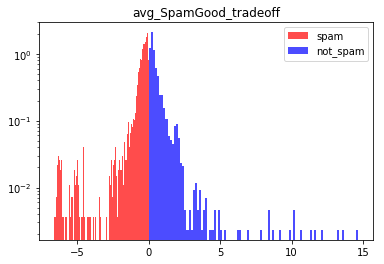

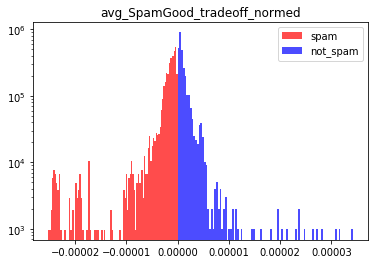

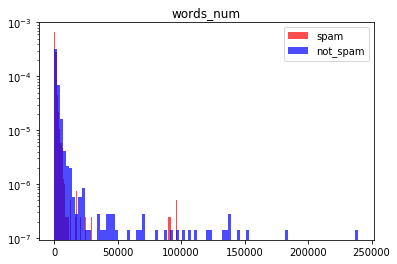

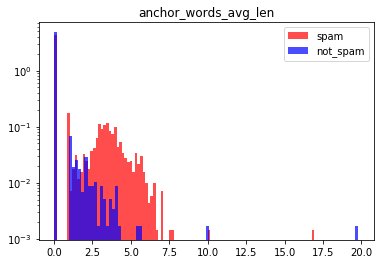

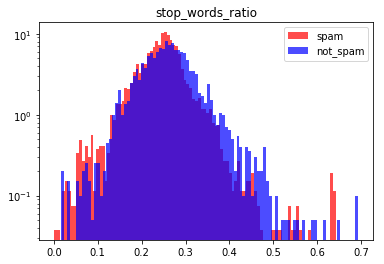

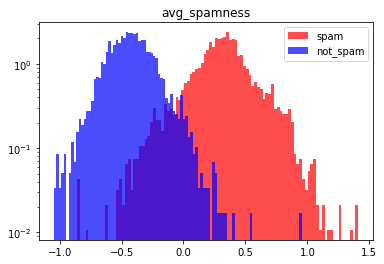

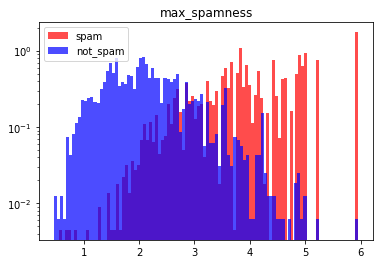

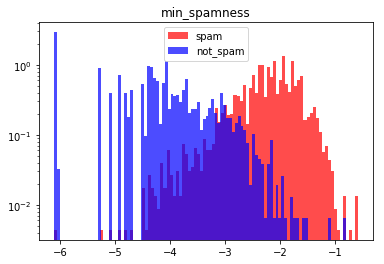

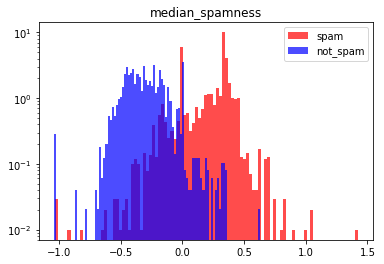

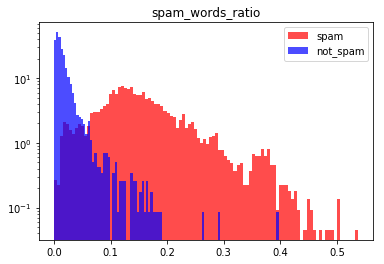

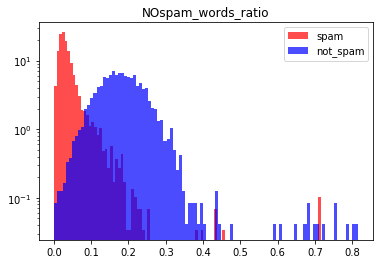

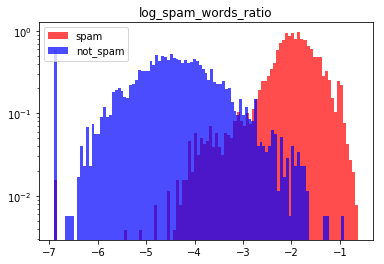

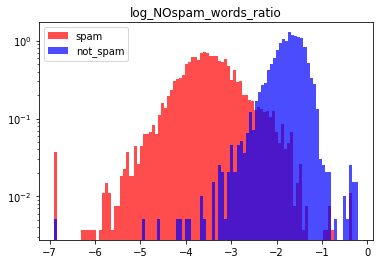

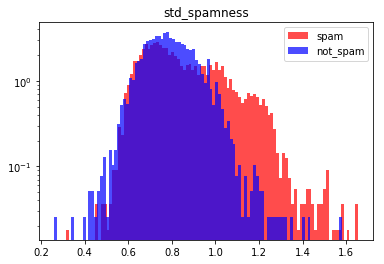

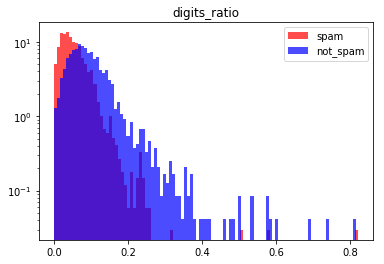

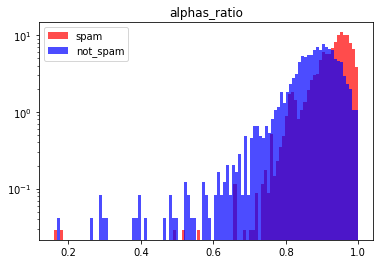

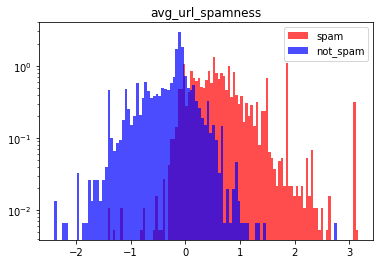

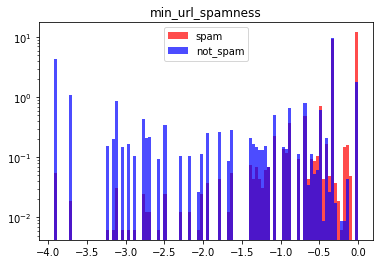

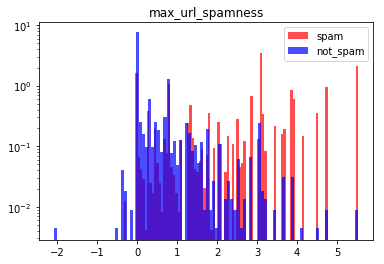

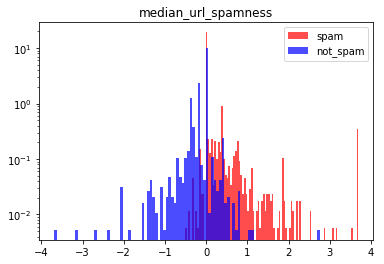

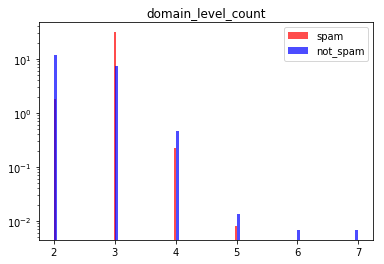

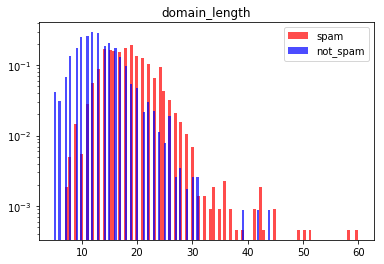

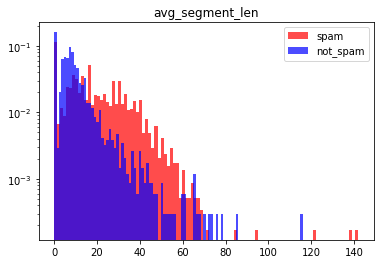

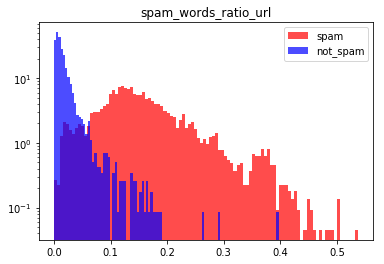

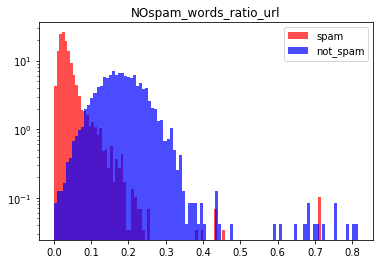

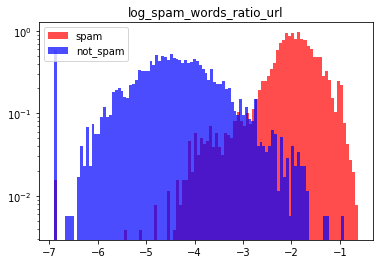

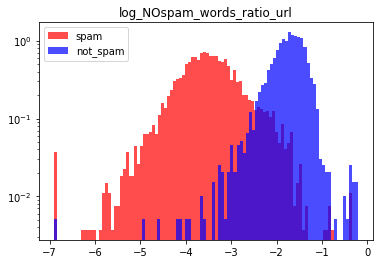

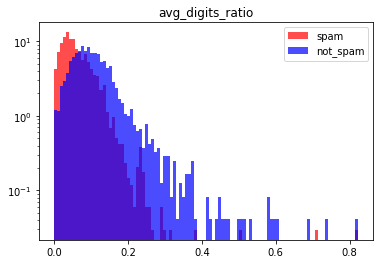

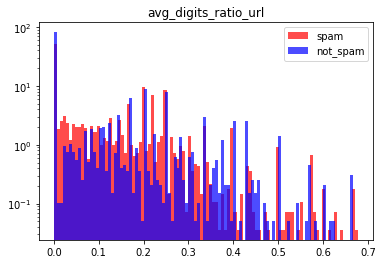

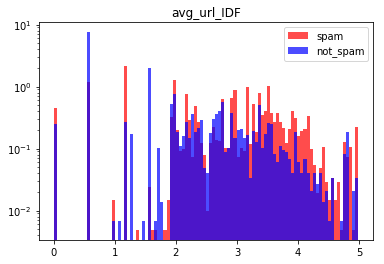

In [39]:
for name in feature_names:
    plot_hist(train_docs, name, bins=100, title=name, logscale=True)

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
import sklearn

** Классификатор: **
Нужно реализовать

In [41]:
class Predictor():
    def __init__(self):
        self.clfs = [RandomForestClassifier(n_estimators=200),
                     LogisticRegression(C=100),
                     KNeighborsClassifier(n_neighbors=5),
                     SVC(C=2, max_iter=500, gamma=0.19),
                     GaussianNB()
                    ]
        self.threshold=threshold
        
    def fit(self, X, y):
        for clf in self.clfs:
            clf.fit(X=X, y=y)
    
    def predict(self, X):
        predictions = []
        avg_X = sum([clf.predict(X) for clf in self.clfs])
        return (avg_X > 1).astype(np.int)
        

def cross_validation(predictor, X, y, cv=5):
    index = np.arange(y.size)
    X_shuffled = X[index]
    y_shuffled = y[index]
    X_folds = np.array_split(X_shuffled, cv)
    y_folds = np.array_split(y_shuffled, cv)
    
    scores = []
    
    for i in range(cv):
        X_train = np.concatenate(X_folds[:i] + X_folds[i + 1:])
        y_train = np.concatenate(y_folds[:i] + y_folds[i + 1:])
        X_test = X_folds[i]
        y_test = y_folds[i]
        predictor.fit(X_train, y_train)
        y_pred = predictor.predict(X_test)
        scores.append(f1_score(y_test, y_pred, average='macro'))
    
    return scores

In [42]:
class Classifier:
    
    def __init__(self, clf=LogisticRegression(), scaler=None, features=None, cv=5):
        self.clf = clf
        self.scaler = scaler
        self.cv = cv
        self.features = features

    def predict(self, doc):
        #if doc.features['domain_name_score'] > 0:
        #    return True
        x = pd.DataFrame(doc.features, index=[0])
        if self.features is not None:
            x = x[self.features]
        x = x.values
        if self.scaler is not None:
            x = self.scaler.transform(x)
        return self.clf.predict(x)[0]
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)
            res.append((doc.doc_id, doc.is_spam, doc.url, prediction))
        return res
    
    def train(self, docs):                
        df = pd.DataFrame([doc.features for doc in train_docs])
        '''
        for feature in self.categorial_features:
            one_hot = pd.get_dummies(df[feature])
            df = df.drop(feature, axis=1)
            df = df.join(one_hot)
        '''
        if self.features is not None:
            df = df[self.features]
        X = df.values
        self.feature_names_ = df.columns
        y = np.array([int(doc.is_spam) for doc in docs])
        if self.scaler is not None:
            self.scaler.fit(X)
            scaled_X = self.scaler.transform(X)
        else:
            scaled_X = X
        scores = cross_validation(self.clf, scaled_X, y, cv=self.cv)
        self.clf.fit(scaled_X, y)
        return np.mean(scores)
    
    def feature_importance(self):
        try:
            return self.clf.feature_importances_
        except:
            return ':('

In [43]:
from IPython.display import clear_output

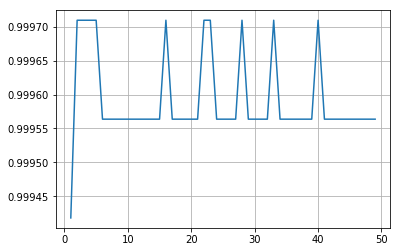

In [44]:
n_depths = np.arange(1, 50)
score = []
depths = []
for depth in n_depths:
    classifier = Classifier(clf=DecisionTreeClassifier(max_depth=depth))
    score.append(classifier.train(train_docs))
    depths.append(depth)
    clear_output(wait=True)
    plt.plot(depths, score)
    plt.grid()
    plt.show()

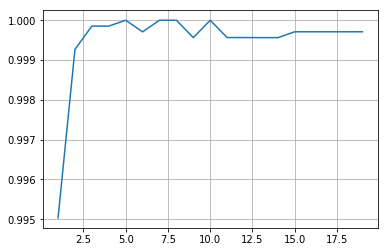

In [45]:
num_features = np.arange(1, 20)
scores = []
features = []
for num in num_features:
    features.append(num)
    classifier = Classifier(clf=RandomForestClassifier(n_estimators=200, max_features=num))
    scores.append(classifier.train(train_docs))
    clear_output()
    plt.plot(features, scores)
    plt.grid()
    plt.show()

In [46]:
features = ['NOspam_words_ratio', 'NOspam_words_ratio_url', 'alphas_ratio',
           'anchor_words_avg_len', 'avg_digits_ratio',
           'avg_digits_ratio_url',
           'avg_url_IDF', 'avg_url_spamness', 'digits_ratio',
           'log_NOspam_words_ratio',
           'log_NOspam_words_ratio_url', 'log_spam_words_ratio',
           'log_spam_words_ratio_url', 'median_spamness', 'median_url_spamness',
           'spam_words_ratio', 'spam_words_ratio_url', 'std_spamness',
           'stop_words_ratio', 'words_num']

In [47]:
classifier = Classifier(clf=RandomForestClassifier(n_estimators=400),
                        features=features,
                        scaler=StandardScaler())
classifier.train(train_docs)

0.9718206885903375

In [49]:
feature_scores = classifier.feature_importance()
feature_names = classifier.feature_names_

scorer = Counter()
for i in range(len(feature_names)):
    scorer[feature_names[i]] = feature_scores[i]
scorer.most_common()

[('NOspam_words_ratio', 0.12690601551257527),
 ('log_NOspam_words_ratio_url', 0.1233813408780949),
 ('NOspam_words_ratio_url', 0.1196873081305081),
 ('log_spam_words_ratio', 0.10607107327889582),
 ('spam_words_ratio_url', 0.09821871486478152),
 ('log_NOspam_words_ratio', 0.09300494224191586),
 ('log_spam_words_ratio_url', 0.0899467313494204),
 ('spam_words_ratio', 0.07466991256231567),
 ('avg_url_spamness', 0.04829906247468521),
 ('median_spamness', 0.025847246810890595),
 ('words_num', 0.01695695358446946),
 ('stop_words_ratio', 0.01117484995440773),
 ('anchor_words_avg_len', 0.010298412797649526),
 ('alphas_ratio', 0.010242357422929886),
 ('median_url_spamness', 0.009900150315538127),
 ('std_spamness', 0.00963969814645607),
 ('avg_digits_ratio', 0.009051461343693012),
 ('digits_ratio', 0.007758413422601244),
 ('avg_url_IDF', 0.0055648842908748546),
 ('avg_digits_ratio_url', 0.0033804706172970616)]

In [50]:
%%time
TEST_DATA_FILE  = './kaggle_test_data_tab.csv.gz'
test_docs = list(load_csv(TEST_DATA_FILE, calc_features, idf, idf_url, log, 
                          log_url, good_words, spam_words, good_words_normed, spam_words_normed))

20:40:50 INFO:Complete items 00000
/Users/g.gospodinov/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/g.gospodinov/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
20:42:31 INFO:Complete items 01000
20:43:59 INFO:Complete items 02000
20:45:19 INFO:Complete items 03000
20:46:31 INFO:Complete items 04000
20:47:41 INFO:Complete items 05000
20:49:00 INFO:Complete items 06000


KeyboardInterrupt: 

In [51]:
for name in feature_names:
    plot_hist(test_docs, name, bins=100, title=name, logscale=True)

NameError: name 'test_docs' is not defined

In [ ]:
preds = [[pred[0], pred[-1]] for pred in classifier.predict_all(test_docs)]

In [ ]:
x = plt.hist(np.array(preds)[:,1])
plt.yscale('log')
plt.show()

In [ ]:
x

In [609]:
%%time

with open('my_submission.csv' , 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in preds:
        prediction = item[1]
        writer.writerow([item[0], prediction])

CPU times: user 37.3 ms, sys: 3.74 ms, total: 41 ms
Wall time: 39.4 ms
